In [1]:
'''
Created on Jul 10, 2016

@author: ssudholt
'''
import numpy as np
from scipy.spatial.distance import pdist, squareform, cdist

def map_from_feature_matrix(features, labels, metric, drop_first):
    '''
    Computes mAP and APs from a given matrix of feature vectors
    Each sample is used as a query once and all the other samples are
    used for testing. The user can specify whether he wants to include
    the query in the test results as well or not.
    
    Args:
        features (2d-ndarray): the feature representation from which to compute the mAP
        labels (1d-ndarray or list): the labels corresponding to the features (either numeric or characters)
        metric (string): the metric to be used in calculating the mAP
        drop_first (bool): whether to drop the first retrieval result or not
    '''
    # argument error checks
    if features.shape[0] != len(labels):
        raise ValueError('The number of feature vectors and number of labels must match')
    # compute the pairwise distances from the
    # features
    dists = pdist(X=features, metric=metric)
    dists = squareform(dists)
    inds = np.argsort(dists, axis=1)
    retr_mat = np.tile(labels, (features.shape[0],1))
    
    # compute two matrices for selecting rows and columns
    # from the label matrix
    # -> advanced indexing
    row_selector = np.transpose(np.tile(np.arange(features.shape[0]), (features.shape[0],1)))
    retr_mat = retr_mat[row_selector, inds]
    
    # create the relevance matrix
    rel_matrix = retr_mat == np.atleast_2d(labels).T
    if drop_first:
        rel_matrix = rel_matrix[:,1:]
        
    # calculate mAP and APs
    map_calc = MeanAveragePrecision()
    avg_precs = np.array([map_calc.average_precision(row) for row in rel_matrix])
    mAP = np.mean(avg_precs)
    return mAP, avg_precs

def map_from_query_test_feature_matrices(query_features, test_features, query_labels, test_labels, 
                                         metric, drop_first=False):
    '''
    Computes mAP and APs for a given matrix of query representations
    and another matrix of test representations
    Each query is used once to rank the test samples.
    
    Args:
        query_features (2d-ndarray): the feature representation for the queries
        query_labels (1d-ndarray or list): the labels corresponding to the queries (either numeric or characters)
        test_features (2d-ndarray): the feature representation for the test samples
        test_labels (1d-ndarray or list): the labels corresponding to the test samples (either numeric or characters)
        metric (string): the metric to be used in calculating the mAP
        drop_first (bool): whether to drop the first retrieval result or not
    '''
    # some argument error checking
    if query_features.shape[1] != test_features.shape[1]:
        raise ValueError('Shape mismatch')
    if query_features.shape[0] != len(query_labels):
        raise ValueError('The number of query feature vectors and query labels does not match')
    if test_features.shape[0] != len(test_labels):
        raise ValueError('The number of test feature vectors and test labels does not match')
    
    # compute the nearest neighbors
    dist_mat = cdist(XA=query_features, XB=test_features, metric=metric)
    retrieval_indices = np.argsort(dist_mat, axis=1)
    
    # create the retrieval matrix
    retr_mat = np.tile(test_labels, (len(query_labels),1))
    row_selector = np.transpose(np.tile(np.arange(len(query_labels)), (len(test_labels),1)))
    retr_mat = retr_mat[row_selector, retrieval_indices]
    
    # create the relevance matrix
    relevance_matrix = retr_mat == np.atleast_2d(query_labels).T
    if drop_first:
        relevance_matrix = relevance_matrix[:,1:]
    
    # calculate mAP and APs
    mapCalc = MeanAveragePrecision()
    avg_precs = np.array([mapCalc.average_precision(row) for row in relevance_matrix], ndmin=2).flatten()
    mAP = np.mean(avg_precs)    
    return mAP, avg_precs

class IterativeMean(object):
    '''
    Class for iteratively computing a mean. With every new value (@see: _add_value)
    the mean will be updated 
    '''
    
    def __init__(self, mean_init=0.0):
        self.__mean = mean_init
        self.__N = 0.0
        
    def add_value(self, value):
        '''
        Updates the mean with respect to value
        
        Args:
            value (float): The value that will be incorporated in the mean
        '''  
        self.__mean = (self.__N / (self.__N + 1)) * self.__mean + (1.0 / (self.__N + 1)) * value
        self.__N += 1
        
    def get_mean(self):
        return self.__mean
    
    def reset(self):
        self.__mean = 0.0
        self.__N = 0.0
         

class MeanAveragePrecision(IterativeMean):
    '''
    Computes average precision values and iteratively updates their mean
    '''
    def __init__(self):
        super(MeanAveragePrecision, self).__init__()        
        
    def average_precision(self, ret_vec_relevance, gt_relevance_num=None):
        '''
        Computes the average precision and updates the mean average precision
        
        Args:
            ret_vec_relevance (1d-ndarray): array containing ground truth (gt) relevance values
            gt_relevance_num (int): The number of relevant samples in retrieval. If None the sum
                                    over the retrieval gt list is used.
        '''
        ret_vec_cumsum = np.cumsum(ret_vec_relevance, dtype=float)
        ret_vec_range = np.arange(1, ret_vec_relevance.size + 1)
        ret_vec_precision = ret_vec_cumsum / ret_vec_range
        
        if gt_relevance_num is None:
            n_relevance = ret_vec_relevance.sum()
        else:
            n_relevance = gt_relevance_num

        if n_relevance > 0:
            ret_vec_ap = (ret_vec_precision * ret_vec_relevance).sum() / n_relevance
        else:
            ret_vec_ap = 0.0
        
        super(MeanAveragePrecision, self).add_value(ret_vec_ap)
        
        return ret_vec_ap

In [2]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

Using TensorFlow backend.


In [3]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
!ls foldered_test

10    1353  1807  2241	268   2846  2938  3031	3118  3209  3298  354  67
1013  1355  1816  2244	2680  2847  2939  3032	3119  3210  3299  355  670
102   1360  1818  2249	2692  2848  2940  3033	312   3211  3300  36   673
1020  1368  182   2254	2695  2849  2941  3034	3120  3212  3301  363  687
1022  1382  1822  2257	2697  2850  2942  3035	3121  3213  3302  365  688
1023  1385  1831  2269	2698  2851  2943  3036	3122  3214  3303  366  694
1026  139   1834  2270	2699  2852  2944  3037	3123  3215  3304  368  695
1027  1391  1835  2274	2711  2853  2945  3038	3124  3216  3305  37   7
1032  1399  1839  2275	2717  2854  2946  3039	3125  3217  3306  371  70
1035  14    184   2280	2722  2855  2947  304	3126  3218  3307  375  701
1036  1400  1842  2285	2724  2856  2948  3040	3127  3219  3308  383  702
104   1404  1849  2289	2727  2857  2949  3041	3128  322   3309  386  708
1040  1408  185   2294	2728  2858  2950  3042	3129  3220  3310  388  717
1041  1434  1852  2296	2729  2859  2951  3043	3130  3221

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

shape of x:  (1, 224, 224, 3)
data type:  float32


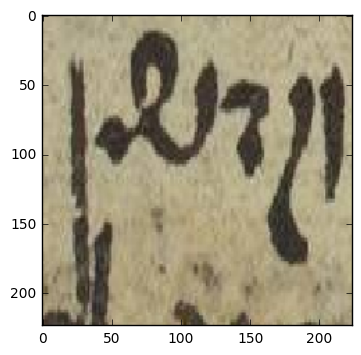

In [7]:
img, x = load_image("foldered_test/3117/3117_1.png")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)
plt.show()

In [8]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
img, x = load_image("foldered_test/3117/3117_1.png")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])
#plt.show()

In [10]:
images_path = 'foldered_test'
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 3200

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 3199 images to analyze


In [11]:
labels=[int(p.split('/')[1]) for p in images]


In [12]:
import time
tic = time.clock()


features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.clock()
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

analyzing image 0 / 3199. Time: 0.0003 seconds.
analyzing image 500 / 3199. Time: 4.4876 seconds.
analyzing image 1000 / 3199. Time: 4.5251 seconds.
analyzing image 1500 / 3199. Time: 4.5107 seconds.
analyzing image 2000 / 3199. Time: 4.7232 seconds.
analyzing image 2500 / 3199. Time: 4.6034 seconds.
analyzing image 3000 / 3199. Time: 5.0565 seconds.
finished extracting features for 3199 images


In [13]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)

PCA(copy=True, n_components=300, whiten=False)

In [14]:
pca_features = pca.transform(features)

In [37]:
pca_features.shape

(3199, 300)

In [15]:
map_measure=map_from_feature_matrix(pca_features, labels, 'cosine', True)


In [16]:
print(map_measure[0])

0.062386075062


In [17]:
import random

# grab a random query image
query_image_idx = int(len(images) * random.random())

# let's display the image
img = image.load_img(images[query_image_idx])
plt.imshow(img)
#plt.show()

In [18]:
from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

In [19]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]

In [20]:
# load all the similarity results as thumbnails of height 100
thumbs = []
for idx in idx_closest:
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)
#plt.show()

In [31]:

def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

In [82]:

# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
#plt.figure(figsize = (5,5))
#plt.imshow(query_image)
#plt.title("query image (%d)" % query_image_idx)

# display the resulting images
#plt.figure(figsize = (16,12))
#plt.imshow(results_image)
#plt.title("result images")
#plt.show()

In [21]:
import pickle

pickle.dump([labels, images, pca_features, pca], open('features_pinkas.p', 'wb'))

In [22]:
%matplotlib inline
import os
import random
import numpy as np
import json
import matplotlib.pyplot
import pickle
from matplotlib.pyplot import imshow
from PIL import Image
from sklearn.manifold import TSNE

In [30]:
labels, images, pca_features, pca = pickle.load(open('features_pinkas.p', 'rb'))

for label, img, f in list(zip(labels, images, pca_features))[0:5]:
    print("image: %i %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(label,img, f[0], f[1], f[2], f[3]))

image: 3093 foldered_test/3093/3093_1.png, features: 17.23,5.88,16.04,10.95... 
image: 3093 foldered_test/3093/3093_2.png, features: 23.74,9.75,-2.29,-10.65... 
image: 3107 foldered_test/3107/3107_1.png, features: 29.28,7.64,-9.47,1.92... 
image: 3100 foldered_test/3100/3100_2.png, features: 25.89,7.42,-16.56,-8.87... 
image: 3100 foldered_test/3100/3100_1.png, features: 29.74,-10.21,-4.88,2.96... 


In [28]:
num_images_to_plot = 3199

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    labels = [labels[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

In [29]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3199
[t-SNE] Computed conditional probabilities for sample 2000 / 3199
[t-SNE] Computed conditional probabilities for sample 3000 / 3199
[t-SNE] Computed conditional probabilities for sample 3199 / 3199
[t-SNE] Mean sigma: 9.335648
[t-SNE] Iteration 25: error = 2.2242932, gradient norm = 0.0000470
[t-SNE] Iteration 25: gradient norm 0.000047. Finished.
[t-SNE] Iteration 50: error = 2.2214358, gradient norm = 0.0085151
[t-SNE] Iteration 75: error = 2.1536505, gradient norm = 0.0125699
[t-SNE] Iteration 100: error = 2.1251090, gradient norm = 0.0109278
[t-SNE] Error after 100 iterations with early exaggeration: 2.125109
[t-SNE] Iteration 125: error = 1.9690686, gradient norm = 0.0057830
[t-SNE] Iteration 150: error = 1.9284996, gradient norm = 0.0050214
[t-SNE] Iteration 175: error = 1.9188839, gradient norm = 0.0048645
[t-SNE] Iteration 200: erro

In [32]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

In [69]:
temp=np.array([tx,ty]).reshape(3199,2)
temp

array([[ 0.58272586,  0.76518065],
       [ 0.74415892,  0.6375444 ],
       [ 0.88778866,  0.26861374],
       ..., 
       [ 0.41762432,  0.06372407],
       [ 0.60387857,  0.63404951],
       [ 0.40072419,  0.41556351]])

In [75]:
map_measure=map_from_feature_matrix(tsne, labels, 'euclidean', True)
print (map_measure[0])

0.0257335865004


In [77]:
width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
#imshow(full_image)

In [41]:
full_image.save("tSNE_pinkas.png")

In [42]:
tsne_path = "tSNE_points_pinkas.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)

saved t-SNE result to tSNE_points_pinkas.json


In [58]:
import rasterfairy

# nx * ny = 1000, the number of images
nx = 50
ny = 64

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

In [78]:
tile_width = 72
tile_height = 56

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    #if (tile_ar > aspect_ratio):
     #   margin = 0.5 * (tile.width - aspect_ratio * tile.height)
      #  tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    #else:
     #   margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
      #  tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    #tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
#imshow(grid_image)

In [74]:
grid_image.save("tSNE_grid_pinkas.jpg")